In [13]:
# !pip install torchaudio==2.3.0

In [ ]:
from inference_loader import InferenceMultimodalLoader
from modeling.multimodal.lm.fromage import FromageMultiModalModeling

In [27]:
import os

workdir = ''

experiment_config = {
    "tokenizer_path": os.path.join(workdir, "ckpts/tokenizer/"),

    "base_llm_path": "Mistral-7B-v0.1/",
    "imagebind_path": 'ckpts/imagebind/imagebing_huge.pth',
    "peft_path": os.path.join(workdir, "ckpts/language_model/"),
    "adapters_path": os.path.join(workdir, "ckpts/projections/modality_adapters.pt"),

    "modality_encoder_mapping": {
        "image": "imagebind_image",
        "audio": "imagebind_audio"
    },
    "n_modality_embs": 4,

    "device": "cpu",
    "image_path": "",
    "audio_path": "",


    "prompt_begin_user": "<RS><user>",
    "prompt_begin_bot": "<RS><bot>",
    "prompt_begin_system": "<RS><system>",
    "system_prompt": "You are an AI assistant. Answer briefly, using a single phrase.",
    "prompt_end_replica": "</RS>",
    "modality_start": "<MS>",
    "modality_end": "</MS>",
    "img_token": "<img>",
    "audio_token": "<audio>",
    "bos": "<s>",
}

In [ ]:
print("Generation config 🫡: ", experiment_config)

EOS_TOKEN = "</RS>"

gen_params = {
    "max_new_tokens": 32,
    "use_cache": True,
    "num_return_sequences": 1,
}


In [29]:
import torch
from typing import Union, Optional, List, Tuple, Dict
from transformers import AutoTokenizer, PreTrainedTokenizer

@torch.no_grad()
def gen_answer(
    model: FromageMultiModalModeling,
    tokenizer: PreTrainedTokenizer,
    context: Optional[torch.Tensor],
    experiment_config: dict
) -> str:
    if "eos_token_id" not in gen_params:
        gen_params['pad_token_id'] = tokenizer.pad_token_id
        gen_params['eos_token_id'] = tokenizer.encode(EOS_TOKEN, add_special_tokens=False)[0]

    out = model.language_model.generate(
        inputs_embeds=context.to(experiment_config["device"]),
        **gen_params,
    )

    generated_answer = tokenizer.batch_decode(out, skip_special_tokens=True)[0]
    return generated_answer


def setup_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(experiment_config["tokenizer_path"], use_fast=False)
    model = InferenceMultimodalLoader.load_model(experiment_config, tokenizer)
    model.eval()
    return model, tokenizer

In [30]:
from utils import get_query_from_input

In [31]:
def generate_text(
    model: FromageMultiModalModeling,
    tokenizer: PreTrainedTokenizer,
    cur_query_list: List[Dict[str, str]],
    experiment_config: dict,
) -> Tuple[str, torch.Tensor]:
    history_tensor: Optional[torch.Tensor] = None
    history_token_ids: Optional[torch.Tensor] = None

    new_replica_input_ids, new_replica_modality_inputs, new_replica_modality_tokens_mask = get_query_from_input(
        model,
        tokenizer,
        cur_query_list,
        experiment_config
    )

    inputs_embeds = model.convert_inputs_to_embeds(
        new_replica_input_ids.unsqueeze(0),
        [new_replica_modality_inputs],
        new_replica_modality_tokens_mask.unsqueeze(0),
    ).to(experiment_config["device"])

    history_tensor = inputs_embeds
    history_token_ids = new_replica_input_ids.unsqueeze(0)

    response_text = gen_answer(model, tokenizer, context=history_tensor, experiment_config=experiment_config)

    return response_text

In [ ]:
model, tokenizer = setup_model_and_tokenizer();

In [32]:
from PIL import Image
import requests

image = Image.open(requests.get("https://i.redd.it/ket76730w05a1.jpg", stream=True).raw)

In [36]:
generate_text(model, tokenizer,
              [
                  {'type': 'text', 'content': "Describe this image."},
                  {'type': 'image', 'content': image}, 
              ],
              experiment_config
             )

'A cat is sitting on a table.'

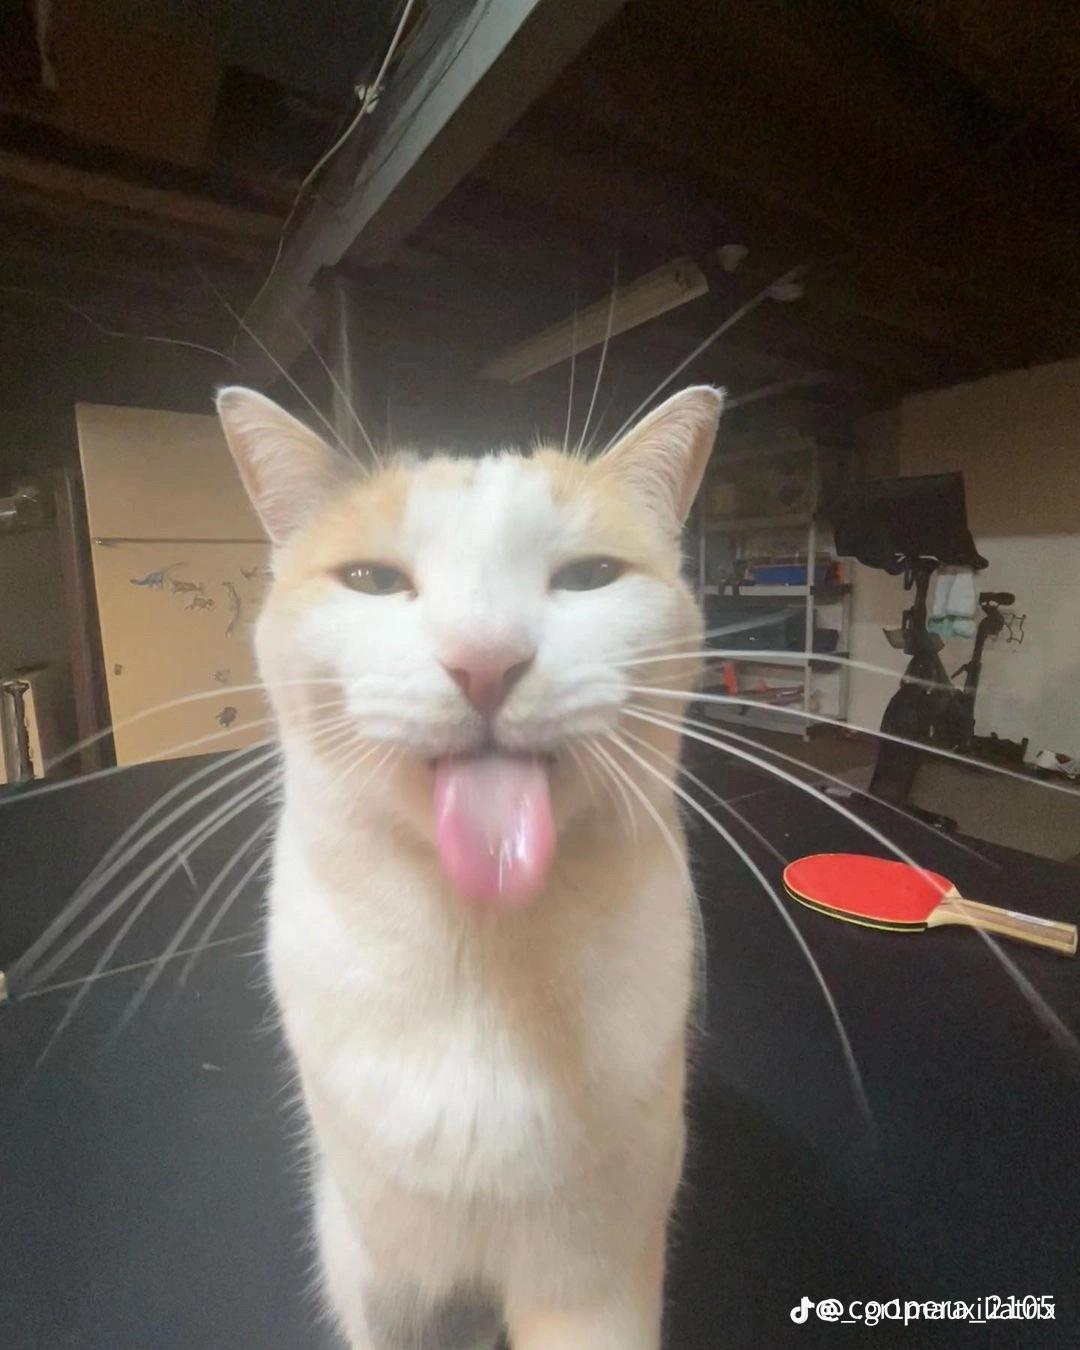

In [37]:
image